<div style="background-color: #0B132B; padding: 20px; border-radius: 10px; border: 3px solid #6FFFE9;">
    <br><br>
    <h1 style="color: #5BC0BE; text-align: center; font-size: 36px; margin-bottom: 15px;">CNN Cancer Detection Kaggle Mini-Project</h1><br>
    <h2 style="color: #4C698D; text-align: center; font-size: 26px; font-weight: bold; margin-top: 0;">by Arne Martin Fevolden (CU Boulder)</h2>
<br><br><br>
</div>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, Image
import PIL
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import time
import concurrent.futures
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

<div style="background-color: #0B132B; padding: 25px; border-radius: 8px; border: 2px solid #6FFFE9; margin-top: 0;">
    <h3 style="color: #5BC0BE; text-align: center; font-size: 26px; margin-top: 30; margin-bottom: 30">Brief Description of the Problem and Data</h3>
</div>

The main task in this competition is to create an algorithm that can identify metastatic tissue in histopathologic scans of lymph node sections. More specifically, the algorithm should, with a high level of accuracy, to be able to classify 57 458 test images as either malignant or normal, where malignant implies that the image contains at least one pixel of tumor tissue in the center 32x32px of the picture. To assist in this task, Kaggle has provided a training dataset consisting of 220 025 images with known labels (malignant or normal). Both the training and test data originate from the PatchCamelyon (PCam) benchmark dataset. The only difference is that the original PCam dataset contains duplicate images due to its probabilistic sampling, while the version provided on Kaggle does not contain duplicates. For more information about the competition see https://www.kaggle.com/c/histopathologic-cancer-detection/overview.

<div style="background-color: #0B132B; padding: 25px; border-radius: 8px; border: 2px solid #6FFFE9; margin-top: 0;">
    <h3 style="color: #5BC0BE; text-align: center; font-size: 26px; margin-top: 30; margin-bottom: 30">Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data</h3>
</div>

In this section, we will ...
* provide a quantitative overview of the training and testing data.
* Verify that the data is sound and can be used in a Convolutional Neural Network (CNN) model
* Visually inspect a few images and verify that they look fine. 

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Useful functions</h3>
</div>

In [2]:
def display_images(image_names, title):
    """
    Displays five images side by side from the 'train' folder.

    :param image_names: List of image file names (without extension)
    :param title: String for title of display
    """
    # Check if there are exactly five images
    if len(image_names) != 5:
        raise ValueError("Please provide exactly five image names")

    # Path to training folder
    folder_path = 'train'

    # Setting up the plot
    plt.figure(figsize=(20, 10))  # Adjust the size as per your preference

    for i, image_name in enumerate(image_names, 1):
        # Construct the full path to the image
        img_path = os.path.join(folder_path, image_name + '.tif')
        img = plt.imread(img_path)
        plt.subplot(1, 5, i)
        plt.imshow(img)
        plt.axis('off')  # Turn off axis numbering

    # Add a title to the figure
    plt.suptitle(title, fontsize=25, y=0.95)

    # Manually adjust the spacing
    plt.subplots_adjust(top=1.38)  # You might need to tweak this value

    plt.show()


def get_first_image_shape(folder_path):
    # Get the first image file from the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    first_image_file = image_files[0] if image_files else None

    if first_image_file:
        # Construct the full path to the first image
        img_path = os.path.join(folder_path, first_image_file)

        # Open the image
        with PIL.Image.open(img_path) as img:
            # Get image dimensions and number of color channels
            width, height = img.size
            num_channels = len(img.getbands())
            return (height, width, num_channels)
    else:
        return None

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Investigation</h3>
</div>

In [3]:
# The Number of images in the dataset
print(f"The Number of training images: {len(os.listdir('train')) : >10}")
print(f"The Number of test images: {len(os.listdir('test')) : >14}")

The Number of training images:     220025
The Number of test images:          57458


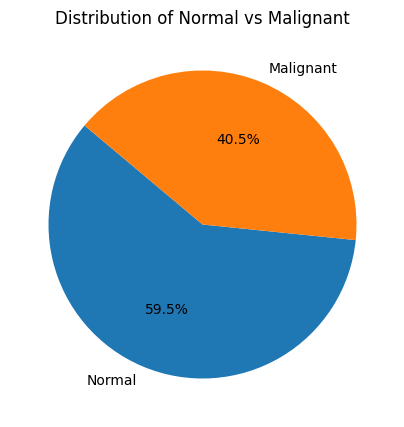

In [4]:
# Load the training and test data labels into a Pandas dataframe
df = pd.read_csv('train_labels.csv')
df_sample = pd.read_csv("sample_submission.csv")

# Count the occurrences of each category in the training set
category_count = df['label'].value_counts().rename({0: 'Normal', 1: 'Malignant'})

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(category_count, labels=category_count.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Normal vs Malignant')
plt.show()

In [5]:
print("Inspection:\n")

print("TRAINING DATA")
print(f"All training labels are valid (0 or 1):        {(df.label.unique().all() in [0, 1])}")
print(f"All training ids are unique (no dublicates):   {len(df.id.unique()) == 220025}")
print(f"There is the same number of ids as images:     {len(df.id.unique()) == 220025}")
print(f"Shape of training image is 96 x 96 x 3:        {get_first_image_shape('train') == (96, 96, 3)}")
print()

print("TESTING DATA")
print(f"All test ids are unique (no dublicates):       {len(df_sample.id.unique()) == 57458}")
print(f"There is the same number of ids as images:     {len(df_sample.id.unique()) == 57458}")
print(f"Shape of testing image is 96 x 96 x 3:         {get_first_image_shape('test') == (96, 96, 3)}")
print()

Inspection:

TRAINING DATA
All training labels are valid (0 or 1):        True
All training ids are unique (no dublicates):   True
There is the same number of ids as images:     True
Shape of training image is 96 x 96 x 3:        True

TESTING DATA
All test ids are unique (no dublicates):       True
There is the same number of ids as images:     True
Shape of testing image is 96 x 96 x 3:         True



In [6]:
malignant = df.loc[df['label']==1]['id'].values
normal    = df.loc[df['label']==0]['id'].values

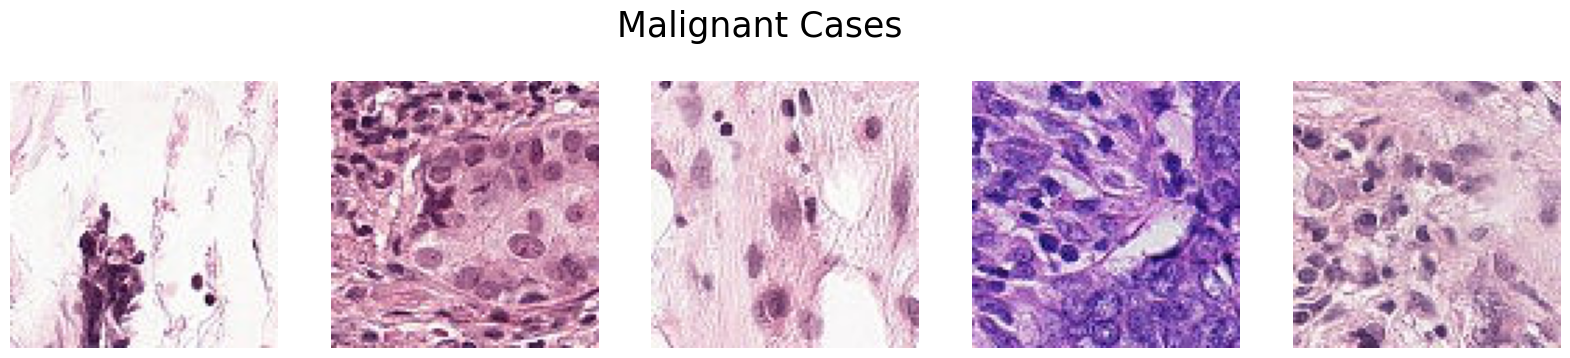

In [7]:
display_images(malignant[:5], 'Malignant Cases')

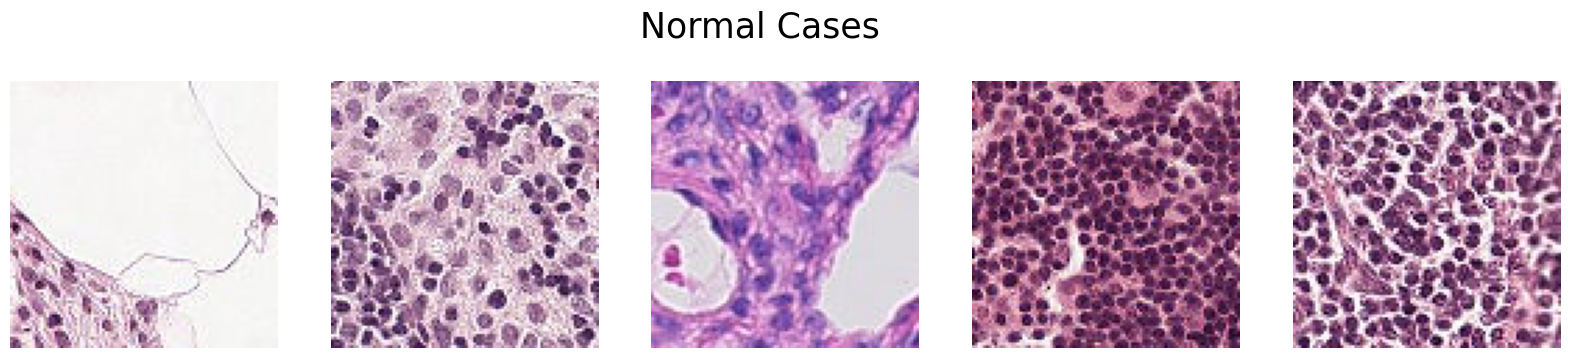

In [8]:
display_images(normal[:5], 'Normal Cases')

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Conclusion</h3>
</div>

Based on our investigations, we can conclude that:

* The dataset is balanced with about 40% malignant cases and 60% normal cases
* All training labels are either 0 (normal) or 1 (malignant)
* There are no duplicates neither in the training nor testing set
* Both the test and training images are of the shape 96 x 96 x 3

This implies that there are good reasons to believe that the data should be suitable for an analysis using Convolutional Neural Network.

<div style="background-color: #0B132B; padding: 25px; border-radius: 8px; border: 2px solid #6FFFE9; margin-top: 0;">
    <h3 style="color: #5BC0BE; text-align: center; font-size: 26px; margin-top: 30; margin-bottom: 30">Model Architecture</h3>
</div>

We will in this section will try out four different CNN architectures:

* **Basic Architecture** with two combined sets of one convolution layer followed by one max pooling layers.
* **Deep Architecture** with three sets of one convolution layer followed by one max pooling layers.
* **Double Convolution Layer Architecture** with two sets of two convolution layers followed by one max pooling layer.
* **Double Deep Architecture** which has three sets of double convolution layers (combination of the two previous architectures).

The principle idea here is to see if we can improve the accuracy of our prediction by adopting specific architectural principles. Adding more layers to a CCN-model should enhance its capacity to learn more complex features from the data. We will test this theory by adopting the Deep Architecture. And adding double convolution layers should allow the network to perform more complex feature extraction before pooling and enable it to better recognize and combine detailed patterns within the input data. We will test that theory by adopting the Double Convolution Layer Architecture. In both cases, we will compare these models with a model that applies a simpler and less sophisticated architecture, which we will refer to as the Basic Architecture. Finally, we will test a Double Deep model that combines both extra layers and double convolution layers. See illustration below.

The models also share some common features. Each of these models will make use of a **dropout layer** before the output layer to add some regularization to the models. The models also apply the principle of **increasing number of filters** in the deeper layers of a convolutional neural network to be able to capture more complex and abstract features in the input data. For more on this topic see for instance Albelwi S, Mahmood A. A Framework for Designing the Architectures of Deep Convolutional Neural Networks. Entropy. 2017; 19(6):242. https://doi.org/10.3390/e19060242.

In this section, we will exclusively focus on the architecture of the CNN and will not try to improve them using different optimizers or regularization techniques. We will do that in the next section after we have settled on a preferred architecture. 

![Example Image](illustrations/architecture.png)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Useful functions</h3>
</div>

In [9]:
def generate_data(df, frac=1.0, test_size=0.2):
    if frac == 1.0:
        df_subset = df.copy()
    else: 
        df_subset = df.sample(frac=frac, replace=False) # Sample the data
    df_subset['label'] = df_subset['label'].astype(str)  # Convert labels to strings
    df_subset['id'] = df_subset['id'].apply(lambda x: f'{x}.tif') # Add the '.tif' extension to the 'id' column
    df_train, df_val = train_test_split(df_subset, test_size=test_size) # Split into training and validation sets

    return df_train, df_val


def create_train_generator(df_train):
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory='train',
        x_col='id',
        y_col='label',
        target_size=(96, 96),
        batch_size=32,
        class_mode='binary'
    )
    return train_generator


def create_val_generator(df_val):
    val_datagen = ImageDataGenerator(rescale=1./255)
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=df_val,
        directory='train',  # Update this if your validation data is in a different directory
        x_col='id',
        y_col='label',
        target_size=(96, 96),
        batch_size=32,
        class_mode='binary'
    )
    return val_generator


def create_early_stopper(monitor='val_accuracy', patience=5):
    early_stopper = EarlyStopping(
        monitor=monitor,
        patience=patience,
        verbose=1,
        restore_best_weights=True
    )
    return early_stopper
    

In [10]:
def plot_training_history(history):
    # Get number of epochs
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training & validation accuracy values
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    

In [11]:
def get_best_epoch_stats(model_names, histories):
    accuracies = []
    losses = []
    
    for model_name, history in zip(model_names, histories):
        # Get the index of the epoch with the highest validation accuracy
        best_epoch_index = np.argmax(history.history['val_accuracy'])
        
        # Retrieve the accuracy and loss for the best epoch
        best_epoch_accuracy = history.history['val_accuracy'][best_epoch_index]
        best_epoch_loss = history.history['val_loss'][best_epoch_index]
        
        # Append the results to the respective lists
        accuracies.append(best_epoch_accuracy)
        losses.append(best_epoch_loss)
    
    return model_names, accuracies, losses
    

In [12]:
def plot_model_metrics(architectures, accuracies, losses):
    # Define colors
    accuracy_color = '#5BC0BE'
    loss_color = '#4C698D'

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Plot accuracy
    axs[0].bar(architectures, accuracies, color=accuracy_color)
    axs[0].set_title('Model Accuracy', fontsize=14)
    axs[0].set_ylabel('Accuracy', fontsize=12)
    axs[0].set_ylim([0, 1])

    # Adding the text labels on the bars
    for i in range(len(accuracies)):
        axs[0].text(i, accuracies[i] + 0.02, f'{accuracies[i]:.2f}', ha='center', va='bottom', color='black')

    # Plot loss
    axs[1].bar(architectures, losses, color=loss_color)
    axs[1].set_title('Model Loss', fontsize=14)
    axs[1].set_ylabel('Loss', fontsize=12)
    axs[1].set_ylim([0, max(losses)+0.1])

    # Adding the text labels on the bars
    for i in range(len(losses)):
        axs[1].text(i, losses[i] + 0.02, f'{losses[i]:.2f}', ha='center', va='bottom', color='white')  # white text for better visibility on dark color

    # Layout adjustments
    plt.tight_layout()

    # Display the plot
    plt.show()


<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Basic Architecture</h3>
</div>

In [26]:
# Create training and validation data
df_train, df_val = generate_data(df, frac=1.0, test_size=0.2)

# Create train and validation generator
train_generator  = create_train_generator(df_train)
val_generator    = create_val_generator(df_val)

# early_stopper
early_stopper    = create_early_stopper(monitor='val_accuracy', patience=5)

# CNN Model Structure with Input layer
model_basic = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_basic.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_basic = model_basic.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 146s 26ms/step - accuracy: 0.7647 - loss: 0.5028 - val_accuracy: 0.8191 - val_loss: 0.4051
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 143s 26ms/step - accuracy: 0.8176 - loss: 0.4155 - val_accuracy: 0.8325 - val_loss: 0.3815
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 145s 26ms/step - accuracy: 0.8351 - loss: 0.3820 - val_accuracy: 0.8319 - val_loss: 0.3788
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 145s 26ms/step - accuracy: 0.8474 - loss: 0.3584 - val_accuracy: 0.8447 - val_loss: 0.3576
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 145s 26ms/step - accuracy: 0.8606 - loss: 0.3321 - val_accuracy: 0.8456 - val_loss: 0.3563
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 144s 26ms/step - accuracy: 0.8663 - loss: 0.3161 - val_accuracy: 0.8544 - val_loss: 0.3361
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 145s 26ms/step - accuracy: 0.8780 -

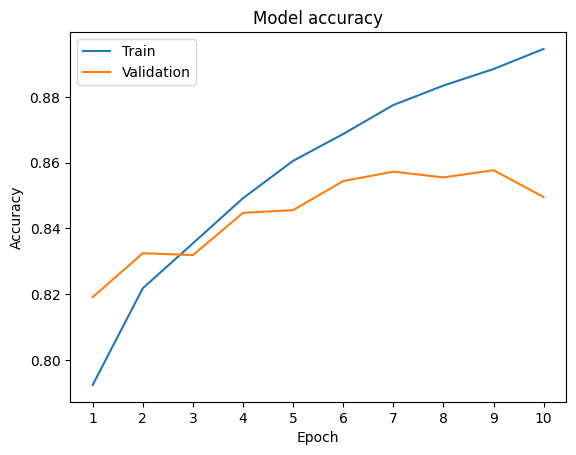

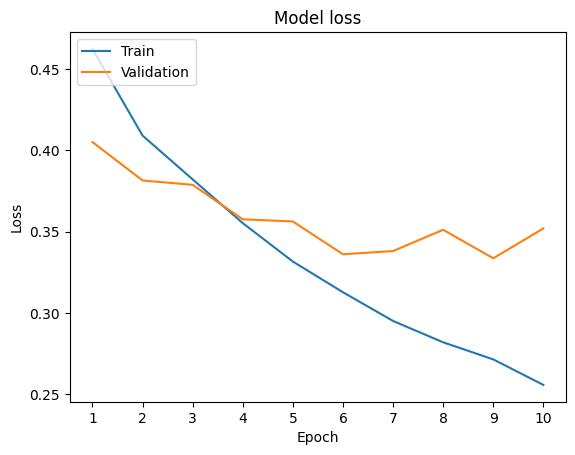

In [27]:
plot_training_history(history_basic)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Deep Architecture</h3>
</div>

In [15]:
# Create training and validation data
df_train, df_val = generate_data(df, frac=1.0, test_size=0.2)

# Create train and validation generator
train_generator  = create_train_generator(df_train)
val_generator    = create_val_generator(df_val)

# early_stopper
early_stopper    = create_early_stopper(monitor='val_accuracy', patience=5)

# CNN Model Structure with Input layer and additional Conv and MaxPooling layers
model_deep = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),  # Additional Conv layer
    MaxPooling2D(2, 2),                      # Additional MaxPooling layer
    Flatten(),
    Dense(128, activation='relu'),  # Increased neurons in the Dense layer
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_deep.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_deep = model_deep.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 153s 28ms/step - accuracy: 0.7803 - loss: 0.4739 - val_accuracy: 0.8449 - val_loss: 0.3709
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 155s 28ms/step - accuracy: 0.8578 - loss: 0.3394 - val_accuracy: 0.8803 - val_loss: 0.2955
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 157s 29ms/step - accuracy: 0.8823 - loss: 0.2897 - val_accuracy: 0.8949 - val_loss: 0.2594
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 155s 28ms/step - accuracy: 0.8951 - loss: 0.2599 - val_accuracy: 0.9020 - val_loss: 0.2445
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 156s 28ms/step - accuracy: 0.9027 - loss: 0.2435 - val_accuracy: 0.8951 - val_loss: 0.2673
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 157s 29ms/step - accuracy: 0.9099 - loss: 0.2290 - val_accuracy: 0.9066 - val_loss: 0.2382
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 156s 28ms/step - accuracy: 0.9149 -

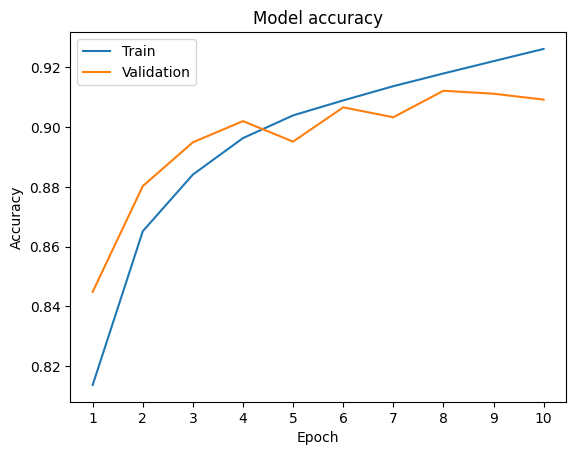

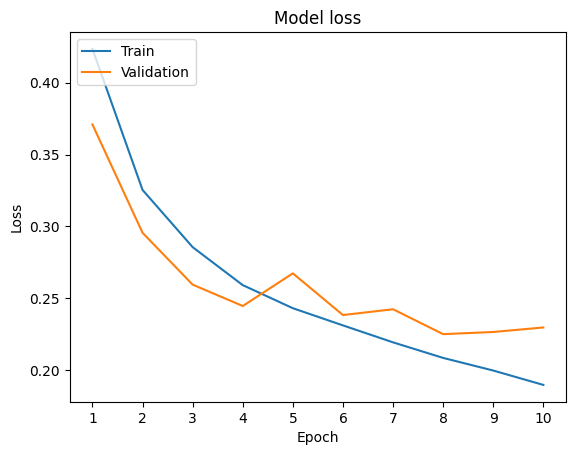

In [16]:
plot_training_history(history_deep)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Double Convolution Layer Architecture</h3>
</div>

In [17]:
# Create training and validation data
df_train, df_val = generate_data(df, frac=1.0, test_size=0.2)

# Create train and validation generator
train_generator  = create_train_generator(df_train)
val_generator    = create_val_generator(df_val)

# early_stopper
early_stopper    = create_early_stopper(monitor='val_accuracy', patience=5)

# CNN Model Structure with double convolution layers
model_doubleConv = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile and train the model as before
model_doubleConv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history_doubleConv= model_doubleConv.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 207s 37ms/step - accuracy: 0.7722 - loss: 0.4839 - val_accuracy: 0.8637 - val_loss: 0.3308
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 206s 37ms/step - accuracy: 0.8649 - loss: 0.3298 - val_accuracy: 0.8851 - val_loss: 0.2805
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 206s 37ms/step - accuracy: 0.8828 - loss: 0.2948 - val_accuracy: 0.8893 - val_loss: 0.2678
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 206s 37ms/step - accuracy: 0.8973 - loss: 0.2591 - val_accuracy: 0.9012 - val_loss: 0.2508
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 206s 37ms/step - accuracy: 0.9060 - loss: 0.2399 - val_accuracy: 0.8939 - val_loss: 0.2582
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 206s 37ms/step - accuracy: 0.9142 - loss: 0.2212 - val_accuracy: 0.9023 - val_loss: 0.2473
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 207s 38ms/step - accuracy: 0.9195 -

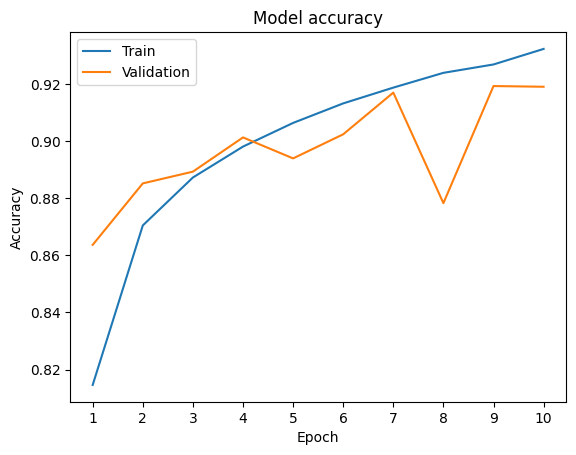

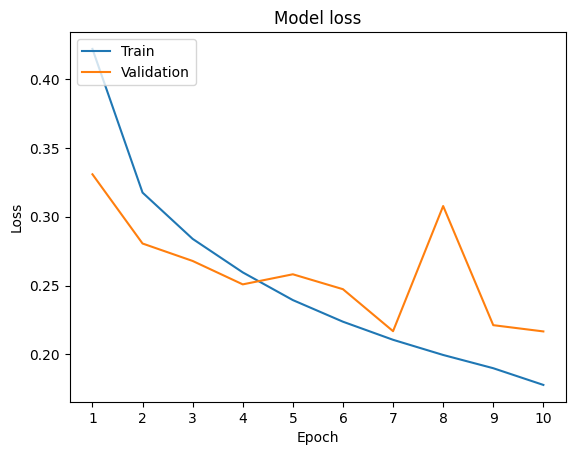

In [18]:
plot_training_history(history_doubleConv)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Double Deep Architecture</h3>
</div>

In [19]:
# Create training and validation data
df_train, df_val = generate_data(df, frac=1.0, test_size=0.2)

# Create train and validation generator
train_generator  = create_train_generator(df_train)
val_generator    = create_val_generator(df_val)

# early_stopper
early_stopper    = create_early_stopper(monitor='val_accuracy', patience=5)

# CNN Model Structure with double convolution layers
model_doubleDeep = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),  # Additional Conv layer
    Conv2D(128, (3, 3), activation='relu'),  # Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile and train the model as before
model_doubleDeep.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history_doubleDeep = model_doubleDeep.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 241s 44ms/step - accuracy: 0.7756 - loss: 0.4843 - val_accuracy: 0.8569 - val_loss: 0.3366
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 240s 44ms/step - accuracy: 0.8608 - loss: 0.3353 - val_accuracy: 0.8869 - val_loss: 0.2708
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 239s 43ms/step - accuracy: 0.8894 - loss: 0.2789 - val_accuracy: 0.9052 - val_loss: 0.2338
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 240s 44ms/step - accuracy: 0.9052 - loss: 0.2444 - val_accuracy: 0.9163 - val_loss: 0.2118
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 240s 44ms/step - accuracy: 0.9158 - loss: 0.2213 - val_accuracy: 0.9151 - val_loss: 0.2142
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 240s 44ms/step - accuracy: 0.9216 - loss: 0.2083 - val_accuracy: 0.9090 - val_loss: 0.2515
Epoch 7/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 240s 44ms/step - accuracy: 0.9259 -

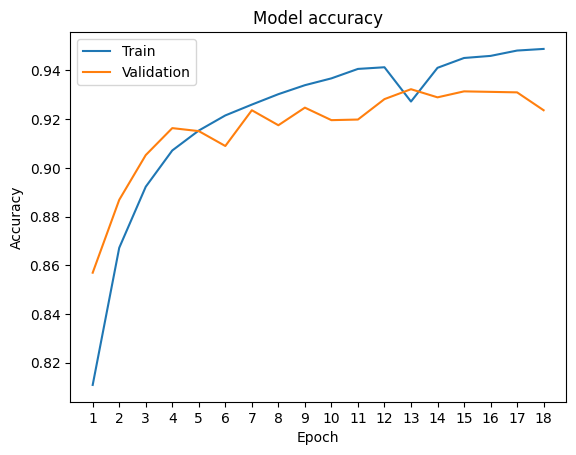

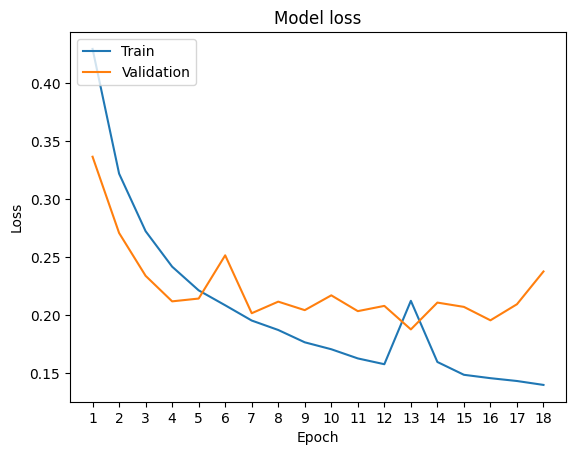

In [20]:
plot_training_history(history_doubleDeep)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Optional Utilities</h3>
</div>

In [21]:
# Plot models
#plot_model(model_basic, to_file='images/model_basic.png', show_shapes=True, show_layer_names=True)
#plot_model(model_deep, to_file='images/model_deep.png', show_shapes=True, show_layer_names=True)
#plot_model(model_doubleConv, to_file='images/model_doubleConv.png', show_shapes=True, show_layer_names=True)
#plot_model(model_doubleDeep, to_file='images/model_doubleDeep.png', show_shapes=True, show_layer_names=True)
#print("All images finished")

In [23]:
# Save models
#model_basic.save('models/model_basic.keras')
#model_deep.save('models/model_deep.keras')
#model_doubleConv.save('models/model_doubleConv.keras')
#model_doubleDeep.save('models/model_doubleDeep.keras')

# Save history
#with open('history/model_basic.pkl', 'wb') as file:
#    pickle.dump(history_basic.history, file)

#with open('history/model_deep.pkl', 'wb') as file:
#    pickle.dump(history_deep.history, file)

#with open('history/model_doubleConv.pkl', 'wb') as file:
#    pickle.dump(history_doubleConv.history, file)

#with open('history/model_doubleDeep.pkl', 'wb') as file:
#    pickle.dump(history_doubleDeep.history, file)

In [14]:
# Load models
#model_basic = load_model('models/model_basic.keras')
#model_deep = load_model('models/model_deep.keras')
#model_doubleConv = load_model('models/model_doubleConv.keras')
#model_doubleDeep = load_model('models/model_doubleDeep.keras')

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Conclusion</h3>
</div>

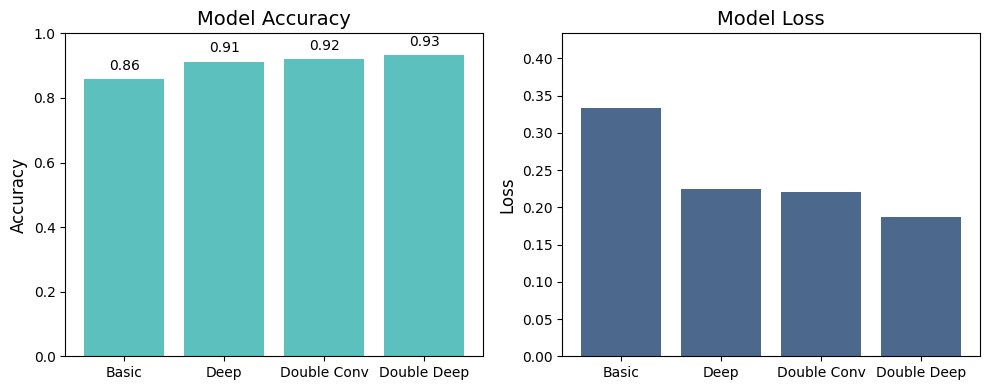

In [28]:
best = get_best_epoch_stats( ('Basic','Deep', 'Double Conv', 'Double Deep'), (history_basic, history_deep, history_doubleConv, history_doubleDeep)  )
plot_model_metrics(*best)

As we can see from the figures above, the Double Deep model outperforms the other three architectures. We will therefore continue using the Double Deep architecture for the rest of this project. An even deeper model architecture could perhaps have resulted in even better results. But due to training time constraints, we will not attempt to train such a model here. Rather we will explore if the DDeep model can be further improved by changing optimizer and introducing regularization.

<div style="background-color: #0B132B; padding: 25px; border-radius: 8px; border: 2px solid #6FFFE9; margin-top: 0;">
    <h3 style="color: #5BC0BE; text-align: center; font-size: 26px; margin-top: 30; margin-bottom: 30">Results and Analysis</h3>
</div>

In this part of the assignment, we will try out different techniques to improve the training or performance. There are many methods one can use to improve the performance of a CNN - such as trying out different optimizers, adding L2 regularization to the neurons in the network, altering the number of neurons dropped by the dropout layers, carrying out batch normalization and trying out different learning rates - to mention a few.

However, the time to train a CNN can be fairly long, and we will not be able in this assignment to test all of these techniques. We will focus on testing the impact of **optimizers** and **L2 regularization**. More specifically, we will test whether another optimizer - RMSprop - can produce better results, and we will see if L2 regularization factor of 0.001 and 0.01 can increase the accuracy. In all cases, we will use our top performing model, which is the Double Deep CNN model.

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Useful functions</h3>
</div>

In [19]:
def preprocess_image(image_path):
    """Load an image and preprocess it for the model."""
    img = load_img(image_path, target_size=(96, 96))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image
    return img_array

def predict_batch(images, model):
    """Predict the labels for a batch of images using the trained model."""
    processed_imgs = np.array([preprocess_image('test/' + img_path + '.tif') for img_path in images])
    predictions = model.predict(processed_imgs)
    predicted_classes = [1 if pred[0] > 0.5 else 0 for pred in predictions]
    return predicted_classes

def process_in_batches(df, batch_size, model):
    """Process the dataframe in batches."""
    num_batches = len(df) // batch_size + (0 if len(df) % batch_size == 0 else 1)
    results = []

    for i in range(num_batches):
        batch = df['id'][i*batch_size:(i+1)*batch_size]
        batch_results = predict_batch(batch, model)
        results.extend(batch_results)
    
    return results

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Optimizers</h3>
</div>

In [30]:
# Create training and validation data
df_train, df_val = generate_data(df, frac=1.0, test_size=0.2)

# Create train and validation generator
train_generator  = create_train_generator(df_train)
val_generator    = create_val_generator(df_val)

# early_stopper
early_stopper    = create_early_stopper(monitor='val_accuracy', patience=5)

model_doubleDeep_RMSprop= Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),  # Additional Conv layer
    Conv2D(128, (3, 3), activation='relu'),  # Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile and train the model as before
model_doubleDeep_RMSprop.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history_doubleDeep_RMSprop = model_doubleDeep_RMSprop.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 231s 42ms/step - accuracy: 0.7634 - loss: 0.5003 - val_accuracy: 0.8694 - val_loss: 0.3151
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 227s 41ms/step - accuracy: 0.8641 - loss: 0.3393 - val_accuracy: 0.8787 - val_loss: 0.2988
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 227s 41ms/step - accuracy: 0.8834 - loss: 0.3049 - val_accuracy: 0.7463 - val_loss: 0.4337
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 227s 41ms/step - accuracy: 0.8789 - loss: 0.3239 - val_accuracy: 0.8860 - val_loss: 0.3134
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 226s 41ms/step - accuracy: 0.8509 - loss: 0.3879 - val_accuracy: 0.8861 - val_loss: 0.3092
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 226s 41ms/step - accuracy: 0.8299 - loss: 0.4437 - val_accuracy: 0.8614 - val_loss: 0.3574
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 226s 41ms/step - accuracy: 0.7998 -

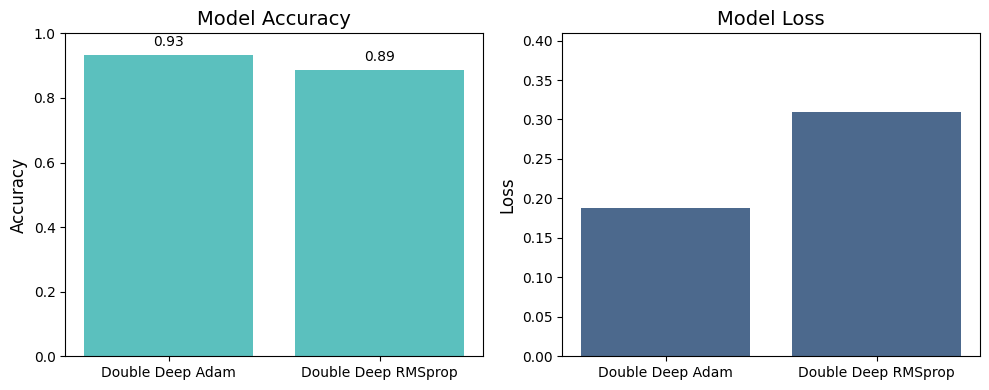

In [31]:
best = get_best_epoch_stats( ('Double Deep Adam', 'Double Deep RMSprop'), (history_doubleDeep, history_doubleDeep_RMSprop)  )
plot_model_metrics(*best)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">L2 Regularization</h3>
</div>

In [32]:
# Create training and validation data
df_train, df_val = generate_data(df, frac=1.0, test_size=0.2)

# Create train and validation generator
train_generator  = create_train_generator(df_train)
val_generator    = create_val_generator(df_val)

# early_stopper
early_stopper    = create_early_stopper(monitor='val_accuracy', patience=5)

# Define L2 regularization factor
l2_factor = 0.001  # This value can be adjusted based on your nee

# CNN Model Structure with Input layer and additional Conv and MaxPooling layers
model_l2_001 = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),# Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),# Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),# Additional Conv layer
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),# Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(l2_factor)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile and train the model as before
model_l2_001.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history_l2_001 = model_l2_001.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 259s 47ms/step - accuracy: 0.6401 - loss: 0.6445 - val_accuracy: 0.8170 - val_loss: 0.4403
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 261s 47ms/step - accuracy: 0.8108 - loss: 0.4588 - val_accuracy: 0.8319 - val_loss: 0.4054
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 258s 47ms/step - accuracy: 0.8172 - loss: 0.4435 - val_accuracy: 0.8437 - val_loss: 0.3894
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 256s 47ms/step - accuracy: 0.8211 - loss: 0.4353 - val_accuracy: 0.8438 - val_loss: 0.3841
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 259s 47ms/step - accuracy: 0.8275 - loss: 0.4273 - val_accuracy: 0.8113 - val_loss: 0.4480
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 257s 47ms/step - accuracy: 0.8296 - loss: 0.4246 - val_accuracy: 0.8409 - val_loss: 0.3924
Epoch 7/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 258s 47ms/step - accuracy: 0.8311 -

In [33]:
# Create training and validation data
df_train, df_val = generate_data(df, frac=1.0, test_size=0.2)

# Create train and validation generator
train_generator  = create_train_generator(df_train)
val_generator    = create_val_generator(df_val)

# early_stopper
early_stopper    = create_early_stopper(monitor='val_accuracy', patience=5)

# Define L2 regularization factor
l2_factor = 0.0001  # This value can be adjusted based on your nee

# CNN Model Structure with Input layer and additional Conv and MaxPooling layers
model_l2_0001 = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),# Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),# Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),# Additional Conv layer
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),# Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(l2_factor)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile and train the model as before
model_l2_0001.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history_l2_0001 = model_l2_0001.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 264s 48ms/step - accuracy: 0.5946 - loss: 0.6827 - val_accuracy: 0.5944 - val_loss: 0.6757
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 258s 47ms/step - accuracy: 0.5971 - loss: 0.6745 - val_accuracy: 0.5944 - val_loss: 0.6752
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 259s 47ms/step - accuracy: 0.5948 - loss: 0.6751 - val_accuracy: 0.5944 - val_loss: 0.6751
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 258s 47ms/step - accuracy: 0.5941 - loss: 0.6754 - val_accuracy: 0.5944 - val_loss: 0.6753
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 259s 47ms/step - accuracy: 0.5951 - loss: 0.6750 - val_accuracy: 0.5944 - val_loss: 0.6753
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 258s 47ms/step - accuracy: 0.5951 - loss: 0.6750 - val_accuracy: 0.5944 - val_loss: 0.6752
Epoch 6: early stopping
Restoring model weights from the end of the best epoc

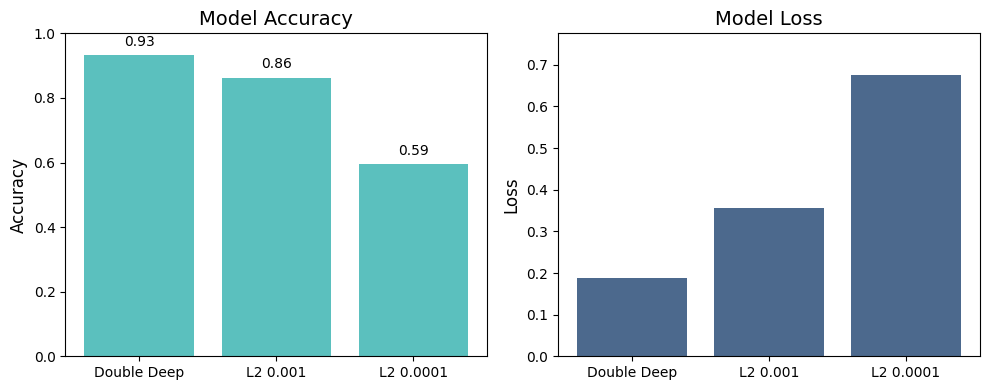

In [35]:
best = get_best_epoch_stats( ('Double Deep', 'L2 0.001', 'L2 0.0001'), (history_doubleDeep, history_l2_001, history_l2_0001)  )
plot_model_metrics(*best)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Optional Utilities</h3>
</div>

In [37]:
model_doubleDeep_RMSprop.save('models/model_doubleDeep_RMSprop.keras')
model_l2_001.save('models/model_l2_001.keras')
model_l2_0001.save('models/model_l2_0001.keras')

# Save history
with open('history/model_doubleDeep_RMSprop.pkl', 'wb') as file:
    pickle.dump(history_doubleDeep_RMSprop.history, file)

with open('history/model_l2_001.pkl', 'wb') as file:
    pickle.dump(history_l2_001.history, file)

with open('history/model_l2_0001.pkl', 'wb') as file:
    pickle.dump(history_l2_0001.history, file)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Conclusion</h3>
</div>

In this part, we saw that ...

* Altering the optimizer to RMSprop did not improve the performance of the model. Our inital model, which was using Adam, had a significantly higher accuracy.
* L2 regularization did not improve the model either. The combination of a lot of data, a dropout layer and a l2 regularization seem to have resulted in over-regularization and a model that was unable to fit the training data. This is the case even though we added a small about of l2 regularization.
* Therefore we keep our best model, which is the Double Deep.

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Prediction for Kaggle</h3>
</div>

In [ ]:
df_sample = pd.read_csv("sample_submission.csv")
df_sample

In [20]:
start = time.perf_counter()
batch_size = 100  # Adjust the batch size based on your system's capability
df_sample['label'] = process_in_batches(df_sample, batch_size, model_doubleDeep)
end = time.perf_counter()
print(end - start)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━

In [22]:
df_sample.to_csv('kaggle.csv', index=False)

<div style="background-color: #0B132B; padding: 15px; border-radius: 8px; border: 2px solid #6FFFE9; margin-top: 20px;">
    <h3 style="color: #5BC0BE; text-align: left; font-size: 22px; margin-top: 0;">Conclusion</h3>
</div>

In this assignment, we have seen that it is possible to build a CNN model that can identify metastatic tissue in histopathologic scans of lymph node section with a reasonably good accuracy. We saw that our top performing model managed to classify images as malignant or normal with an accuracy of , according to the validaiton set. This assignment also led to some interesting findings concerning CNNs.  

* Architecture seem to be very important compared to more conventional hyper parameter tuning and regularization.
* Both depth and double convolution layers seem both to add positively to performance and the combinaiton produces very good results.
* It is espacially challenging to try out many combinations of architecture and hyper parameter tunings on CNNs due to their long traing times.